## Channel Network Post Processing

### Set up the Environment

In [4]:
import sys
import subprocess

required_modules = ['fiona', 'shapely', 'pyproj', 'rtree', 'geopandas', 'pandas']

def install_missing_modules():
    python = sys.executable
    for module in required_modules:
        subprocess.check_call([python, '-m', 'pip', 'install', module])

def check_and_install_modules():
    try:
        # Try importing the required modules
        import fiona
        import shapely
        import pyproj
        import rtree
        import geopandas as gpd
        import pandas as pd
        print('The required modules are already installed.')
    except ImportError:
        # Modules not found, install them
        print('Some required modules are missing. Attempting to install...')
        install_missing_modules()
    finally:
        # Attempt imports again after installation
        import fiona
        import shapely
        import pyproj
        import rtree
        import geopandas as gpd
        import pandas as pd
        print('All required modules are now installed and ready to use.')

# Call the function to check and install modules
check_and_install_modules()

The required modules are already installed.
All required modules are now installed and ready to use.


In [5]:
import sys

## A function to show the progress of the analysis
def print_progress_bar(index, total, label):
    ## Progress bar width
    n_bar = 50
    progress = index / total
    sys.stdout.write('\r')
    ## Message
    sys.stdout.write(f"[{'|' * int(n_bar * progress):{n_bar}s}] {int(100 * progress)}%  {label}")
    sys.stdout.flush()

## Find the last segment of each channel, where it joins a bigger channel (drain_nodes).
def find_drain_nodes(shp_file):
    d_nods = shp_file[shp_file['OrderStrah'] < shp_file['TargetOrd']]
    d_nods = d_nods[['STREAM', 'OrderStrah']]
    d_nods = d_nods.sort_values(by=['OrderStrah'], ascending=True)
    return d_nods

## Set the working directory
wd = r"D:\LWS Projects\Thriving Southland\23014_Titiroa\2 Working Files\Working Datasets\1 - Spatial Data\Hydrological_Analysis"

### Level 1 processing

In [32]:
import geopandas as gpd
import pandas as pd

## Detect and join all small links (or watersheds, if the inputs are polygons) that make up a channel
def merge_leve1(args):
    feature_segments, d_nods = args
    
    ## Find all up-stream segments of a feature
    def find_up_stream_segments(id):
        up_segms = feature_segments[feature_segments['Target'] == id]
        return up_segms

    """
        Separate all features with Strahler order 1, as they are already in one piece.
        These will be joined to the rest of merged features when returning the final
            channel network or watersheds layer.
    """
    d_nods = d_nods[d_nods['OrderStrah'] > 1]
    merged_features = feature_segments[feature_segments['OrderStrah'] == 1]

    """
        Find all segments that make up a feature (excluding their contributory channels)
            and merge them into a single feature.
        For example, if the feature (channel or watershed) has Strahler order 4, the
            product of this function will not include smaller channels with Strahler
            order 3, 2, and 1 that contribute to it.
    """
    counter = 0
    total = len(d_nods)

    for id in d_nods['STREAM']:
        segments = feature_segments[feature_segments['STREAM'] == id]
        order = int(segments.OrderStrah.iloc[0])
        
        ## Find up-stream links of the current link in a channel
        up_segments = find_up_stream_segments(id)
        segments = pd.concat([segments, up_segments], ignore_index=True)
        
        while len(up_segments) > 0:
            lev_n_segments = gpd.GeoDataFrame()
            for lev_n_id in up_segments['STREAM']:
                lev_n_segment = find_up_stream_segments(lev_n_id)
                lev_n_segments = pd.concat([lev_n_segments, lev_n_segment], ignore_index=True)

            up_segments = lev_n_segments
            segments = pd.concat([segments, up_segments], ignore_index=True)

            segments = segments[segments['OrderStrah'] == order]
            
        ## Dissolve all sections into one feature
        segment = segments.dissolve()
        segment['STREAM'] = int(id)

        ## Add the current feature to the results
        merged_features = pd.concat([merged_features, segment], ignore_index=True)

        """
            Find all channels that drain into the current channel and change their "Target"
                attribute to the ID ("STREAM") of the current channel. 
        """
        for trg in segments['STREAM']:
            merged_features.loc[merged_features['Target'] == trg, 'Target'] = int(id)

        counter += 1
        print_progress_bar(counter, total, "Percent of the data has been processed")

    ## Join attributes of the original shapefile to the merged shapefile
    merged_features = gpd.GeoDataFrame(merged_features[['STREAM', 'Target', 'geometry']])
    merged_features = merged_features.merge(feature_segments[['STREAM', 'OrderStrah', 'TargetOrd']], \
                                            on='STREAM', suffixes=(None, '_T'))
    merged_features = merged_features[['STREAM', 'OrderStrah', 'Target', 'TargetOrd', 'geometry']]
    
    return merged_features

,STREAM,OrderStrah,Target,TargetOrd,geometry
0,3,1,4.0,2,"LINESTRING (1279000.500 4854826.500, 1278999.5..."
1,4,2,5.0,2,"LINESTRING (1278574.500 4854906.500, 1278574.4..."
2,5,2,8.0,2,"LINESTRING (1278563.500 4854870.500, 1278560.5..."
3,6,1,5.0,2,"LINESTRING (1278578.500 4854812.500, 1278576.5..."
4,7,1,8.0,2,"LINESTRING (1278920.500 4854667.500, 1278917.5..."
...,...,...,...,...,...
7808,7931,1,7924.0,2,"LINESTRING (1282635.500 4830757.500, 1282634.5..."
7809,7932,1,7928.0,2,"LINESTRING (1282814.500 4830835.500, 1282811.5..."
7810,34,4,78.0,5,"LINESTRING (1278361.500 4853936.700, 1278360.4..."
7811,1275,6,1431.0,6,"LINESTRING (1272872.500 4847780.500, 1272870.7..."


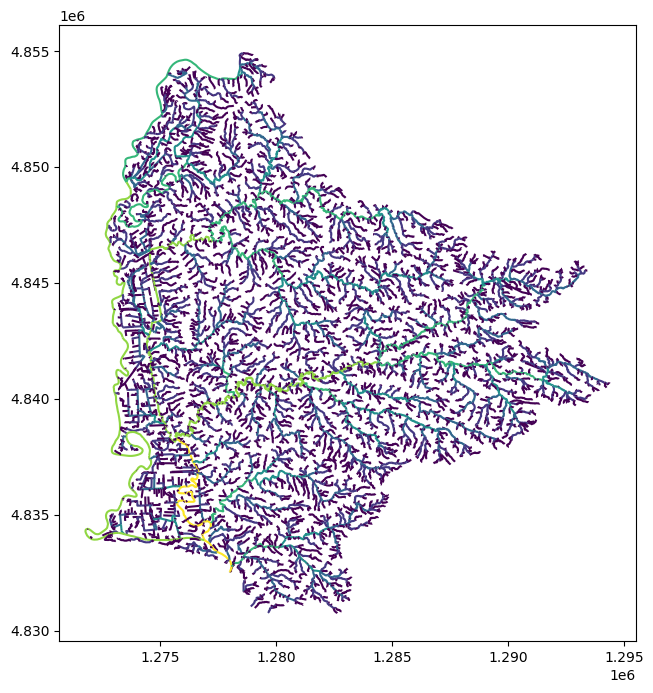

In [60]:
import geopandas as gpd

## Read and represent the shapefile
f_dir = f'{wd}/Titiroa_DEM1m_Dep10m_ChanellNetwork_V2.shp'
features = gpd.read_file(f_dir)
features.plot(column='OrderStrah', figsize=(12, 8)) ## 'OrderStrah' can be changed to any attribute in the shapefile
features

In [53]:
## Find the drain node of each channel (not stream links)
drain_nodes = find_drain_nodes(features)
drain_nodes

,STREAM,OrderStrah
0,6440,1
4894,4020,1
4896,4010,1
4897,4009,1
4901,4013,1
...,...,...
557,754,5
7380,5891,6
6847,7454,6
6946,6033,6


Merging the features ...
[||||||||||||||||||||||||||||||||||||||||||||||||||] 100%  Percent of the data has been processedn\Saving the results ...


,STREAM,OrderStrah,Target,TargetOrd,geometry
0,6440,1,6444.0,2,"MULTIPOLYGON (((1281726.000 4837237.000, 12817..."
1,6439,1,6474.0,2,"POLYGON ((1285505.000 4837524.000, 1285506.000..."
2,6466,1,6482.0,2,"POLYGON ((1282245.000 4837254.000, 1282246.000..."
3,6463,1,6468.0,2,"POLYGON ((1277693.000 4837390.000, 1277694.000..."
4,6470,1,6358.0,2,"MULTIPOLYGON (((1283142.000 4836852.000, 12831..."
...,...,...,...,...,...
5026,754,5,7454.0,6,"MULTIPOLYGON (((1273434.000 4849458.655, 12734..."
5027,5891,6,7736.0,7,"MULTIPOLYGON (((1276320.000 4838449.000, 12763..."
5028,7454,6,7736.0,7,"MULTIPOLYGON (((1271836.000 4833984.000, 12718..."
5029,6033,6,7736.0,7,"MULTIPOLYGON (((1274792.000 4841060.000, 12747..."


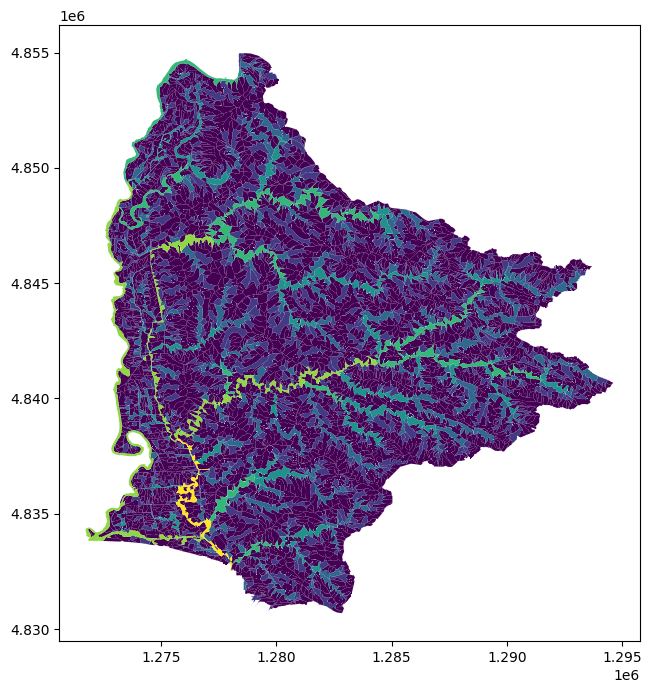

In [54]:
import os
import pandas as pd

print('Merging the features ...')
args_list = [features, drain_nodes]
merged_features_lev1 = merge_leve1(args_list)

## Save the results
print('n\Saving the results ...')
f_name = os.path.splitext(os.path.basename(f_dir))[0]
f_ext = os.path.splitext(os.path.basename(f_dir))[1]
out_dir = f'{wd}/{f_name}_Merged_L1{f_ext}'
merged_features_lev1.to_file(out_dir, crs=features.crs)

# #Represent the results
merged_features_lev1.plot(column='OrderStrah', figsize=(12,8))
merged_features_lev1

### Level 2 processing

In [55]:
import geopandas as gpd
import pandas as pd

## Detect and join all channels (or watersheds, if the inputs are polygons) that drain from the current point
def merge_leve2(args):
    feature_segments, d_nods = args
    ## Find the up-stream segment(s) of a channel.
    def find_up_stream_segments(id):
        up_channels = feature_segments[feature_segments['Target'] == id]
        return up_channels

    """
        Separate all features with Strahler order 1, as they are already in one piece.
        These will be joined to the rest of merged features when returning the final
            channel network or watersheds layer.
    """
    d_nods = d_nods[d_nods['OrderStrah'] > 1]#.iloc[1000:2000]
    merged_features = feature_segments[feature_segments['OrderStrah'] == 1]
    ## Get the Strahler order of the biggest stream in the catchment
    max_order = max(d_nods['OrderStrah'])

    """
        Find all segments that make up a feature (INCLUDING their contributory channels)
            and merge them into a single feature.
        For example, if the feature (channel or watershed) has Strahler order 4, the
            product of this function WILL INCLUDE smaller channels with Strahler
            order 3, 2, and 1 that contribute to it.
    """
    counter = 0
    total = len(d_nods)
    for id in d_nods['STREAM']:
        segments = feature_segments[feature_segments['STREAM'] == id]
        
        ## Find up stream links of the current link in a channel
        up_segments = find_up_stream_segments(id)
        segments = pd.concat([segments, up_segments], ignore_index=True)
        
        while len(up_segments) > 0:
            lev_n_segments = gpd.GeoDataFrame()
            for lev_n_id in up_segments['STREAM']:
                lev_n_segment = find_up_stream_segments(lev_n_id)
                lev_n_segments = pd.concat([lev_n_segments, lev_n_segment], ignore_index=True)
            up_segments = lev_n_segments
            segments = pd.concat([segments, up_segments], ignore_index=True)
        
        ## Dissolve all sections into one feature
        segment = segments.dissolve()
        segment['STREAM'] = int(id)
        
        ## Add the current feature to the results
        merged_features = pd.concat([merged_features, segment], ignore_index=True)

        counter += 1
        print_progress_bar(counter, total, "Percent of the data has been processed")

    ## Join attributes of the original shapefile to the merged shapefile
    merged_features = gpd.GeoDataFrame(merged_features[['STREAM', 'Target', 'geometry']])
    merged_features = merged_features.merge(feature_segments[['STREAM', 'OrderStrah', 'TargetOrd']],
                                            on='STREAM', suffixes=(None,'_T'))
    merged_features = merged_features[['STREAM', 'OrderStrah', 'Target', 'TargetOrd', 'geometry']]

    return merged_features

In [57]:
import os
import geopandas as gpd

# ## Read and represent the shapefile
# f_dir = f'{wd}/Titiroa_DEM1m_Dep10m_CaptureZones_V2_Merged_L1.shp'
# merged_features_lev1 = gpd.read_file(f_dir)

# ## Find the drain node of each channel (not stream links)
# drain_nodes = find_drain_nodes(merged_features_lev1)
# drain_nodes

# print('Merging the features ...')
# args_list = [merged_features_lev1, drain_nodes]
# merged_features_lev2 = merge_leve2(args_list)

# ## Save the results
# print('\n Saving the results ...')
# # f_name = os.path.splitext(os.path.basename(f_dir))[0]
# # f_ext = os.path.splitext(os.path.basename(f_dir))[1]
out_dir = f'{wd}/{f_name}_Merged_L2{f_ext}'
merged_features_lev2.to_file(out_dir, crs=features.crs)

# #Represent the results
# merged_features_lev2.plot(column='OrderStrah', figsize=(12,8))
# merged_features_lev2

### Level 3 processing

In [58]:
import numpy as np
import pandas as pd

## Calculate the traveling distance from a drain point, along the channel network, to the last drain point in the channel network
def calc_dis_to_drain(channel_links):
    d_nods = channel_links[(channel_links['OrderStrah'] < channel_links['TargetOrd'])]#.iloc[:10]
    counter = 0
    total = len(d_nods)
    
    """
        Find all segments that make up a channel and merge them into a single channel. For example, a channel with order 6 will include all its upper channel segment plus all channels with smaller order
    """
    channels_l = gpd.GeoDataFrame()
    for index, channel in d_nods.iterrows():
        counter2 = 0
        channel_id = channel.STREAM
        n_channel_id = channel.Target
        target_channel = channel_links[channel_links['STREAM'] == n_channel_id]
        l_to_h = 0

        while len(target_channel) > 0:
            # print(type(target_channel.length))
            t_length = target_channel.length
            l_to_h = l_to_h + t_length.iloc[0]
            n_channel_id = target_channel.Target.iloc[0]
            target_channel = channel_links[channel_links['STREAM'] == n_channel_id]

            if n_channel_id == 200002:
                break
            if counter2 == 300:
                break
            counter2 = counter2 + 1

        counter = counter + 1
        print_progress_bar(counter, total, "Percent of the data has been processed")
        ## Add the current feature to the results
        channel['Dis2EndP'] = l_to_h
        channels_l = pd.concat([channels_l, channel], axis=1, ignore_index=True)
    
    channels_l = channels_l.transpose()
    
    ## Convert the channels to a point geodataframe that represents the drain points
    geom_dis2drain =  channels_l.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
    last_vertices = geom_dis2drain.apply(lambda x: x[-1])
    x_coords = last_vertices.apply(lambda x: x[0])
    y_coords = last_vertices.apply(lambda x: x[1])
#     pts_coords = pd.concat([x_coords.rename('XCoords'), y_coords.rename('YCoords')], axis=1)
    
    ## Join attributes of the original shapefile to the resulted shapefile
    channels_l = channels_l.merge(channel_links[['STREAM', 'OrderStrah', 'TargetOrd']],
                                  on='STREAM', suffixes=(None,'_T'))
    channels_l = channels_l[['STREAM', 'OrderStrah', 'Target', 'TargetOrd', 'Dis2EndP']]
    
    ## Create the geopandas point geodataframe 
    pt_drains = gpd.GeoDataFrame(channels_l, \
                                 geometry=gpd.points_from_xy(x_coords, y_coords), \
                                 crs=channel_links.crs)
    return pt_drains

In [61]:
## Read and represent the shapefile
drain_points = calc_dis_to_drain(features)
drain_points
drain_points.to_file(f'{wd}/drain_points.shp')

[||||||||||||||||||||||||||||||||||||||||||||||||||] 100%  Percent of the data has been processed